## Motion Planning  
#### Gal Schechter 

### Imports

In [353]:
import cv2  
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
from IPython.display import Image

### Load Map

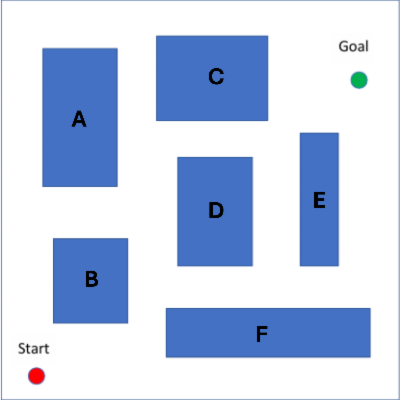

In [354]:
fn = "fig.png"
IMG_SIZE =400
GRID_SIZE =10
img =cv2.imread(fn)
img =cv2.resize(img,(IMG_SIZE ,IMG_SIZE))
cv2.imwrite(fn,img)
Image(filename=fn)

### Get Points Of Interest

In [355]:
def get_map():
    '''
        0- top|left
        1- top|right
        2- bottom|left
        3- bottom|right
    '''
    rect ={}
 
    rect['E']=np.array([(300,135),
                        (340,135),
                        (300,265),
                        (340,265)])
    
    rect['F']= np.array([(165,310),
                        (370,310),
                        (165,360),
                        (370,360)])
    
    rect['D']= np.array([(178,158),
                        (250,158),
                        (178,265),
                        (250,265)])
    
    rect['C']= np.array([(155,35),
                        (270,35),
                        (155,120),
                        (270,120)])
    
    rect['B']= np.array([(52,238),
                        (130,238),
                        (52,325),
                        (130,325)])
    
    rect['A']= np.array([(40,45),
                        (115,45),
                        (40,190),
                        (115,190)])

    return rect

def get_Goals():
    points ={}
    points['S'] = (35,375)
    points['G'] = (360,80)
    return points

def get_all_points():
    goals=get_Goals()
    obst = get_map()
    points =[]

    for p in goals.values():
        points.append(p)
    for o in obst.values():
        for p in o:
            points.append(p)
    return points

### Collision Check

In [356]:
def check_point_in_rect(P,rect):
    return (rect[0][0]<P[0] and P[0]<rect[3][0]) and (rect[0][1]<P[1] and P[1]<rect[2][1])

def check_collusion(Ps,Pg):
    obst = get_map()
    res = 100
    line = np.linspace(Ps,Pg,res)

    for rect in obst.values():
        for p in line:
            if(check_point_in_rect(p,rect)):
                return True
    return False


### Uniform Grid (10x10)

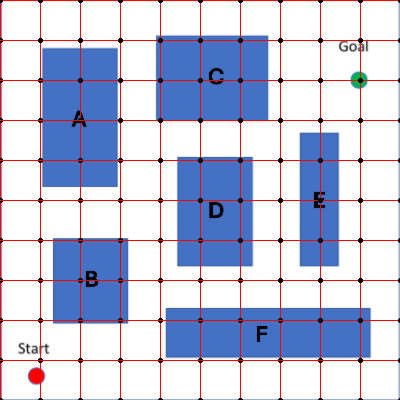

In [357]:
def get_grid_map():
    img =cv2.imread('fig.png')

    for i in range(0,img.shape[0]+1,int(img.shape[0]/GRID_SIZE)):
        img =cv2.line(img,(0,i),(IMG_SIZE,i),color=(0,0,255),thickness=1)
        img =cv2.line(img,(i,0),(i,IMG_SIZE),color=(0,0,255),thickness=1)
        for j in range(0,img.shape[0]+1,int(img.shape[0]/GRID_SIZE)):
            img =cv2.circle(img,center=(i,j),color=(0,0,0),radius=1,thickness=2)

    cv2.imwrite('grid_map.png',img)
get_grid_map()
Image(filename='grid_map.png')

### Tangent Graph

676


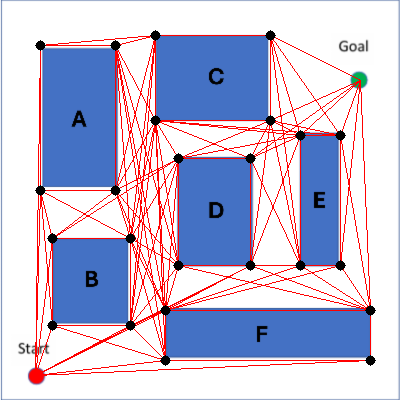

In [358]:
def get_tangent_map():
    img =cv2.imread('fig.png')
    points = get_all_points()
    goals  =get_Goals()
    i=0
    for pi in points:
        for pf in points:
            i+=1
            if not check_collusion(pi,pf):
                img = cv2.line(img,pi,pf,color=(0,0,255),thickness=1)
                if tuple(pf) == goals['S'] or tuple(pf) == goals['G']:
                    continue
                img = cv2.circle(img, center=pf,color=(0,0,0), radius=2, thickness=5)
    print(i)

    cv2.imwrite('tangent_map.png',img)

get_tangent_map()
Image(filename='tangent_map.png')


### Veroni Graph

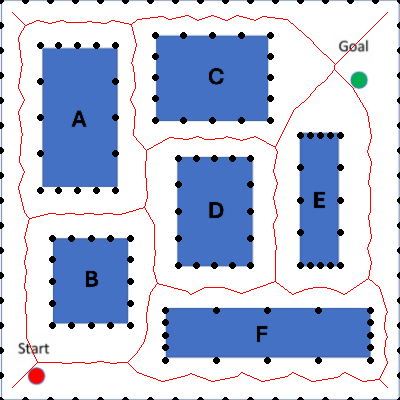

In [359]:

def get_varoni_map():
    img =cv2.imread('fig.png')
    img_h, img_w = [IMG_SIZE,IMG_SIZE]
    density =5
    points =[]
    obst_map = get_map()
    for k in get_map().keys():   
        obs = obst_map[k]
        points.append(obs[0])
        points.append(obs[1])
        points.append(obs[2])
        points.append(obs[3])
        for dy in np.linspace(0,obs[2][1]- obs[0][1],density):
            dy = int(dy)
            points.append([obs[0][0],obs[0][1]+dy])
            points.append([obs[1][0],obs[1][1]+dy])
        for dx in np.linspace(0,obs[1][0]- obs[0][0],density):
            dx = int(dx)
            points.append([obs[0][0]+dx,obs[0][1]])
            points.append([obs[2][0]+dx,obs[2][1]])
    step =25
    for i in range(0,IMG_SIZE+step,step):
        points.append([0,i])
        points.append([i,0])
        points.append([IMG_SIZE,i])
        points.append([i,IMG_SIZE])
    for p in points:
        img = cv2.circle(img,p,2,(0,0,0),2,2)
    vor = Voronoi(points,)
    for start, end in vor.ridge_vertices:
        if start >= 0 and end >= 0: 
            p1 = tuple(map(int, vor.vertices[start]))
            p2 = tuple(map(int, vor.vertices[end]))
            if  (0 <= p1[0] < IMG_SIZE and 0 <= p1[1] < IMG_SIZE and 0 <= p2[0] < IMG_SIZE and 0 <= p2[1] < IMG_SIZE) and (not check_collusion(p1,p2)):
                img = cv2.line(img, p1, p2, (0,0,255), 1)        
    cv2.imwrite('veroni_map.png',img)


get_varoni_map()
Image(filename='veroni_map.png')


### Drawing & Graph Util Functions

In [360]:
def get_grid():
    img =cv2.imread('fig.png')
    grid  = {}
    obst = get_map()
    for i in range(0,IMG_SIZE,int(IMG_SIZE/GRID_SIZE)):
        for j in range(0,IMG_SIZE,int(IMG_SIZE/GRID_SIZE)):
            grid_p =(i*GRID_SIZE/IMG_SIZE,j*GRID_SIZE/IMG_SIZE)
            grid[grid_p] = 1
            for o in obst.values():
                if check_point_in_rect((i,j),o):
                    grid[grid_p] = 100
    return grid

def get_neighbors(p):
        neighbors = []
        for dx,dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nx = p[0] + dx
            ny = p[1] + dy
            if 0 <= nx < GRID_SIZE and 0 <= ny < GRID_SIZE:  # Check bounds
                neighbors.append((nx, ny))
        return neighbors

def draw_path(img,path,scale =True):
        n_path = path
        path =[]
        if scale:
            for p in n_path:
                px,py =p
                px*= IMG_SIZE/GRID_SIZE
                py*= IMG_SIZE/GRID_SIZE
                path.append((px,py))
        path = np.array(path, dtype=np.int32).reshape((-1, 1, 2))
        img = cv2.polylines(img,[path],isClosed=False,color=(255,0,0),thickness=2)
        return img

def draw_cost(img,costs,scale =True):
        for p in costs.keys():
            c =costs[p]
            px,py = p
            px*= IMG_SIZE/GRID_SIZE
            py*= IMG_SIZE/GRID_SIZE
            org = [int(px),int(py)]
            cv2.putText(img,str(c), org, cv2.FONT_HERSHEY_PLAIN, 0.8, (0, 0, 0), 2, cv2.LINE_AA)
        return img

### Dijkstra Path

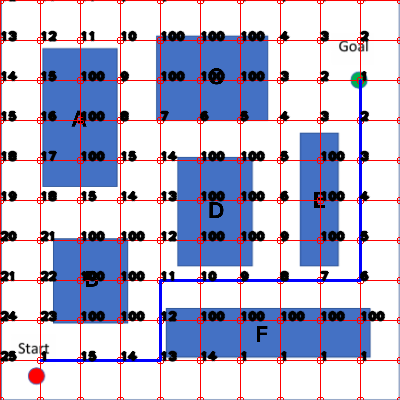

In [361]:
def dijkstra():
    res_to_gird = GRID_SIZE/IMG_SIZE
    goals = get_Goals()
    start_p =tuple(np.round(np.array(goals['S'])*res_to_gird))
    goal_p =tuple(np.round(np.array(goals['G'])*res_to_gird))
    w_grid = get_grid()
    visited = [goal_p]
    current_p = goal_p 
    paths = []
    path = [ goal_p]

    tot_cost = 1
    to_check =[]
    while True:
        neighbors = get_neighbors(current_p)
        next = {}
        for n in neighbors:
            if n == start_p:
                  current_p = start_p
                  path.append(start_p)
                  break
            if n in visited:
                    continue

            visited.append(n)
            if w_grid[n]+w_grid[current_p]>100:
                continue
            w_grid[n] += w_grid[current_p]
            next[n] = w_grid[n]
        
        if(len(next) == 0):
            if len(to_check)>0:
                if current_p == start_p:
                   paths.append(path.copy())
                path= to_check.pop(0)
                current_p = path[-1]
            else:
                 break
        else:
            current_p = min(next,key=next.get)
            for p in next:
                if w_grid[current_p] == w_grid[p] and p != current_p:
                    n_path =path.copy()
                    n_visted= visited.copy()
                    n_path.append(n)
                    to_check.append(n_path)
            path.append(current_p)

    min_cost = w_grid[paths[0][-2]]
    best_path =paths[0]
    for path in paths:
        if (min_cost>w_grid[path[-2]]):
            best_path =path
            min_cost =w_grid[path[-2]]
    img = cv2.imread('grid.png')
    img = draw_path(img,best_path)
    img = draw_cost(img,w_grid)
    
    cv2.imwrite('dikst.png',img)

    return path


dijkstra()
Image(filename='dikst.png')

### A* by distance

In [362]:
def get_AS_grid():
    img =cv2.imread('fig.png')
    grid  = {}
    obst = get_map()
    res_to_gird = GRID_SIZE/IMG_SIZE
    goals = get_Goals()
    start_p =tuple(np.round(np.array(goals['S'])*res_to_gird))
    #goal_p =tuple(np.round(np.array(goals['G'])*res_to_gird))
    for i in range(0,IMG_SIZE,int(IMG_SIZE/GRID_SIZE)):
        for j in range(0,IMG_SIZE,int(IMG_SIZE/GRID_SIZE)):
            grid_p =(i*GRID_SIZE/IMG_SIZE,j*GRID_SIZE/IMG_SIZE)
            grid[grid_p] = 1 + int(( (start_p[0]-grid_p[0])**2 +(start_p[1]-grid_p[1])**2)**0.5)
            for o in obst.values():
                if check_point_in_rect((i,j),o):
                    grid[grid_p] += 100
    return grid

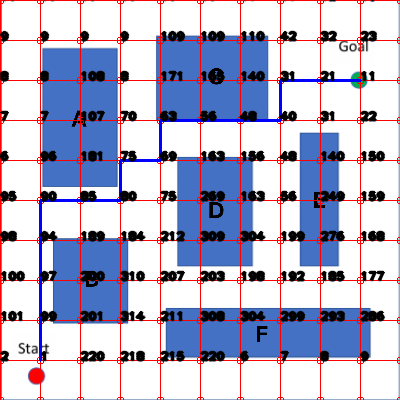

In [363]:
def A_Star():
    
    res_to_gird = GRID_SIZE/IMG_SIZE
    goals = get_Goals()
    start_p =tuple(np.round(np.array(goals['S'])*res_to_gird))
    goal_p =tuple(np.round(np.array(goals['G'])*res_to_gird))
    w_grid = get_AS_grid()

    visited = [goal_p]
    current_p = goal_p 
    paths = []
    path = [ goal_p]
    tot_cost = 1
    to_check =[]
    while True:
        neighbors = get_neighbors(current_p)
        next = {}
        for n in neighbors:
            if n == start_p:
                  current_p = start_p
                  path.append(start_p)
                  break
            if n in visited:

                    continue
            visited.append(n)
            w_grid[n] += w_grid[current_p]
            next[n] = w_grid[n]
        if(len(next) == 0) or current_p == start_p :
            if len(to_check)>0:
                if current_p == start_p:
                   paths.append(path.copy())
                path= to_check.pop(0)
                current_p = path[-1]
            else:
                 break
        else:
            current_p = min(next,key=next.get)
            for p in next:
                if w_grid[current_p] == w_grid[p] and p != current_p:
                    n_path =path.copy()

                    n_path.append(n)
                    to_check.append(n_path)
            path.append(current_p)
    min_cost = w_grid[paths[0][-2]]
    best_path =paths[0]
    for path in paths:
        if (min_cost>w_grid[path[-2]]):
            best_path =path
            min_cost =w_grid[path[-2]]
    img = cv2.imread('grid.png')
    img = draw_path(img,best_path)
    img = draw_cost(img,w_grid)
    cv2.imwrite('A_star.png',img)
    return path


A_Star()
Image(filename='A_star.png')